# Intro to time series forecasting with [`sktime`](https://github.com/alan-turing-institute/sktime)

Main source: [`sktime` documentation](https://www.sktime.org/en/stable/index.html).

Author: Adelson de Araujo (a.dearaujo@utwente.nl)

## Imports

In [ ]:
! pip install sktime --quiet
! pip install pmdarima --quiet
! pip install prophet --quiet

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sktime

## Load some data

In [ ]:
# load some data

from sktime.datasets import load_macroeconomic, load_shampoo_sales, load_airline

Y = load_macroeconomic()
print(type(Y), type(Y.index))
Y.tail()

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.indexes.period.PeriodIndex'>


,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
Period,,,,,,,,,,,,
2008Q3,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
2008Q4,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
2009Q1,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
2009Q2,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19
2009Q3,12990.341,9256.0,1486.398,1044.088,10040.6,216.385,1673.9,0.12,9.6,308.013,3.56,-3.44


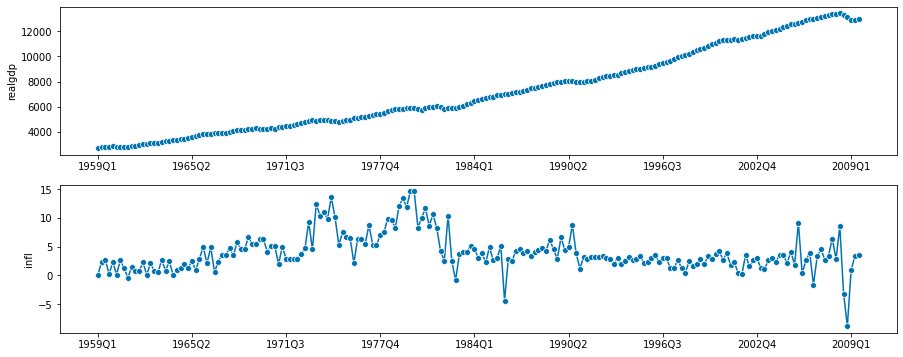

In [ ]:
from sktime.utils.plotting import plot_series

realgdp = Y['realgdp']
infl = Y['infl']

fig, ax = plt.subplots(nrows=2, figsize=(15,6))

plot_series(realgdp, ax=ax[0])
plot_series(infl, ax=ax[1])

## Interpolation vs Regression vs Forecasting

### Interpolation

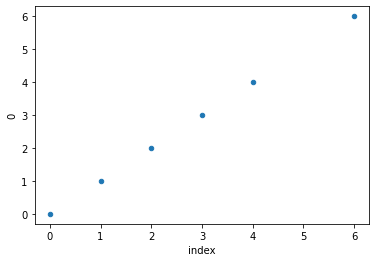

In [ ]:
# More info: https://docs.scipy.org/doc/scipy/reference/interpolate.html#univariate-interpolation

import pandas as pd

s = pd.Series([0, 1, 2, 3, 4,  np.nan,  6])
s.reset_index().plot.scatter(x='index', y=0)

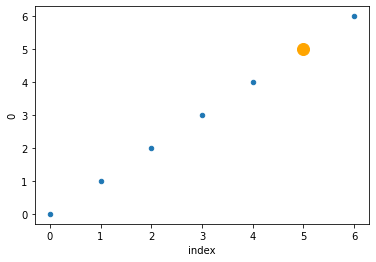

In [ ]:
s_interp = s.interpolate()
s_interp.reset_index().plot.scatter(x='index', y=0)
s_interp[[5]].plot(color='orange', marker='o', markersize=12)

In [ ]:
s = pd.Series([0, 1, 2, 3, 4,  np.nan])
s.reset_index().plot.scatter(x='index', y=0)

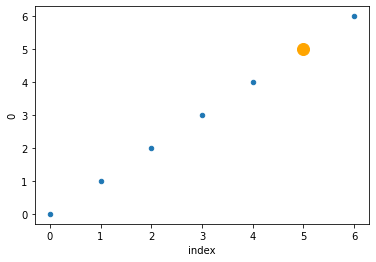

In [ ]:
s_interp = s.interpolate(limit_direction='forward')
s_interp.reset_index().plot.scatter(x='index', y=0)
s_interp[[5]].plot(color='orange', marker='o', markersize=12)

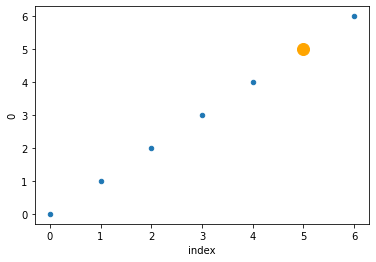

In [ ]:
s_interp = s.interpolate(method='spline', order=1, limit_direction='forward')
s_interp.reset_index().plot.scatter(x='index', y=0)
s_interp[[5]].plot(color='orange', marker='o', markersize=12)

### Regression



```
# FeatureExtraction
y = ...
X = FeatureExtraction.fit_transform(y) # backwards information or not!
```





```
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sktime.forecasting.model_selection import temporal_train_test_split

# X, y
X_train, X_test, y_train, y_test = train_test_split(X, y)

regressor = make_pipeline(
    # FeatureExtraction
    RandomForestRegressor(),
)
regressor.fit(X_train, y_train)
regressor.score(X_test, y_test)
```



### Forecasting

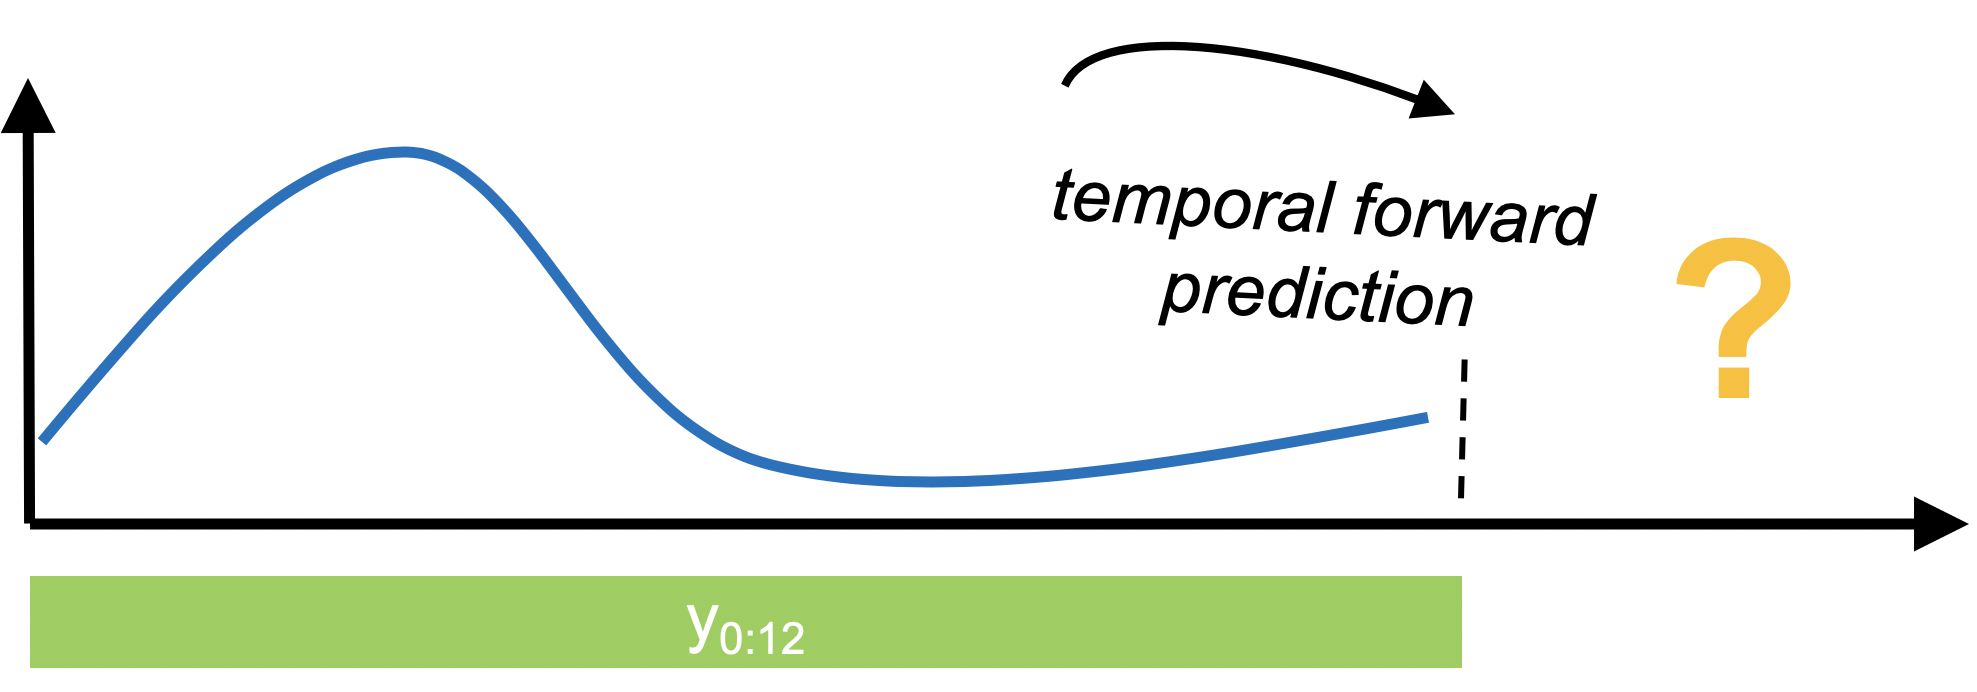

Source: https://www.sktime.org/en/stable/examples/01_forecasting.html.



```
# Convert index to pd.DatetimeIndex
y = y.to_timestamp(freq="M")

y_train, y_test = temporal_train_test_split(y, test_size=36)
```





```
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split

forecaster = make_reduction(
    regressor, scitype="time-series-regressor", window_length=12
)
forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index)
y_pred = forecaster.predict(fh)
```



## ARIMA modeling and baselines

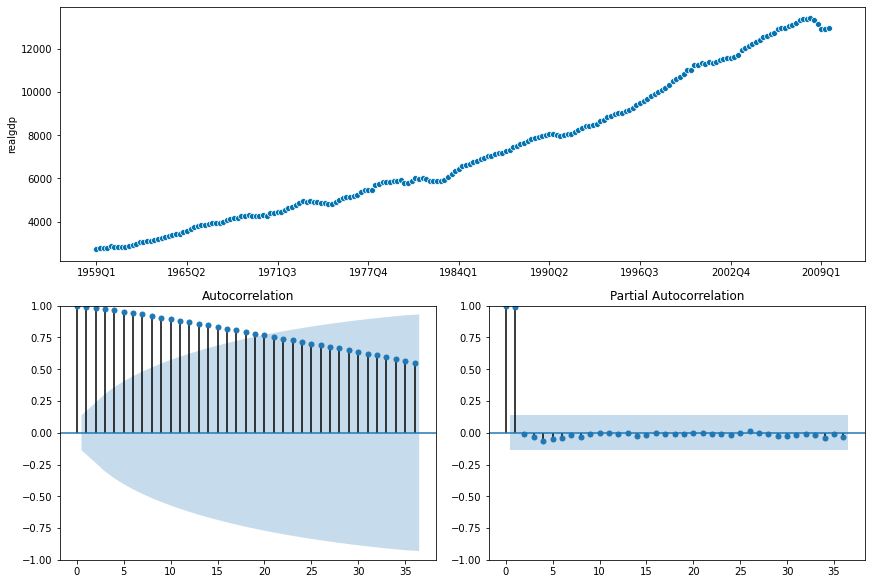

In [ ]:
from sktime.utils.plotting import plot_correlations

plot_correlations(
    realgdp, lags=36, alpha=0.05, pacf_method="ywadjusted",
    acf_title="Autocorrelation", pacf_title="Partial Autocorrelation",
);

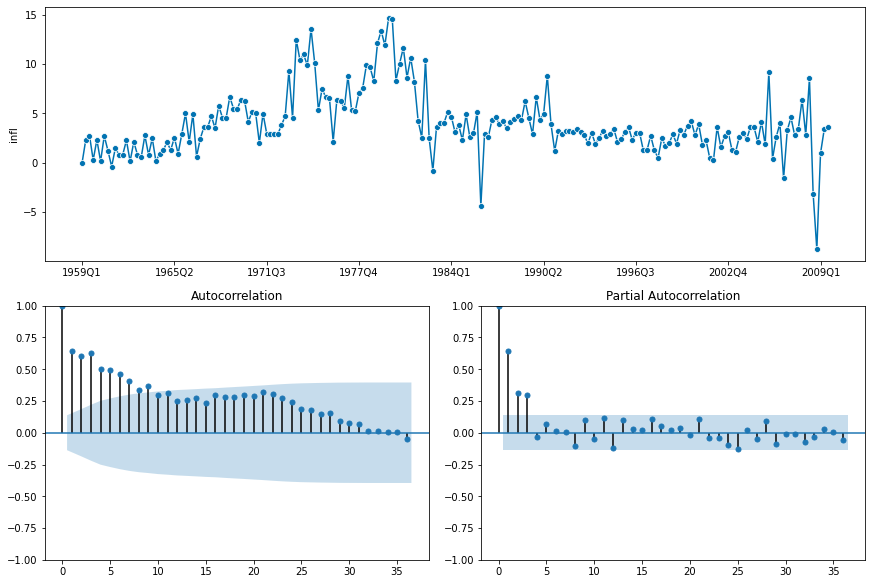

In [ ]:
plot_correlations(
    infl, lags=36, alpha=0.05, pacf_method="ywadjusted",
    acf_title="Autocorrelation", pacf_title="Partial Autocorrelation",
);

In [ ]:
# How to find appropriate parameters for ARIMA? The Box-Jenkins method 
p = ?
q = ? 
d = ? 
...

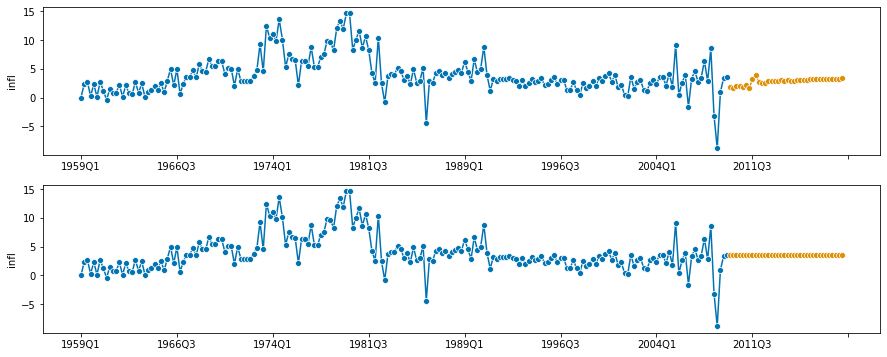

In [ ]:
# AutoARIMA
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.naive import NaiveForecaster

y = infl

# horizon
fh = np.arange(1, 37) # next 3 years

# ARIMA
forecaster = AutoARIMA(sp=12, d=0, max_p=2, max_q=2, suppress_warnings=True)
forecaster.fit(y)
y_pred = forecaster.predict(fh=fh)

# vs NaiveForecaster (random walk)
forecaster = NaiveForecaster()
forecaster.fit(y)
y_pred_naive = forecaster.predict(fh=fh)

fig, ax = plt.subplots(nrows=2, figsize=(15,6))

plot_series(y, y_pred, ax=ax[0])
plot_series(y, y_pred_naive, ax=ax[1])



```
# Other baselines:

NaiveForecaster(strategy='last')
NaiveForecaster(strategy='mean')
NaiveForecaster(strategy='mean', sp=12, window_length=3)
```



## Forecast evaluation workflow in a nutshell

108 36


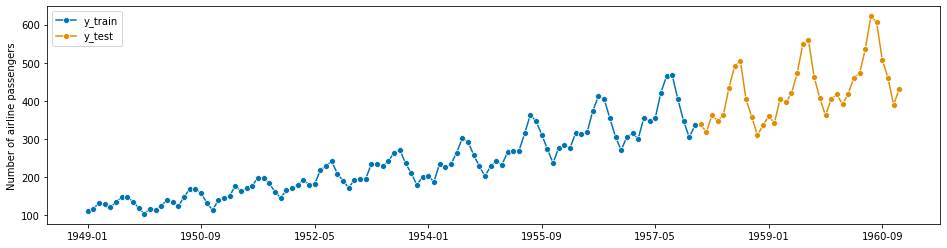

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)

fh = ForecastingHorizon(y_test.index, is_relative=False)

# plotting for illustration
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

{'mean_squared_error': 613.662609655092, 'r2_score': 0.8997005618495348}


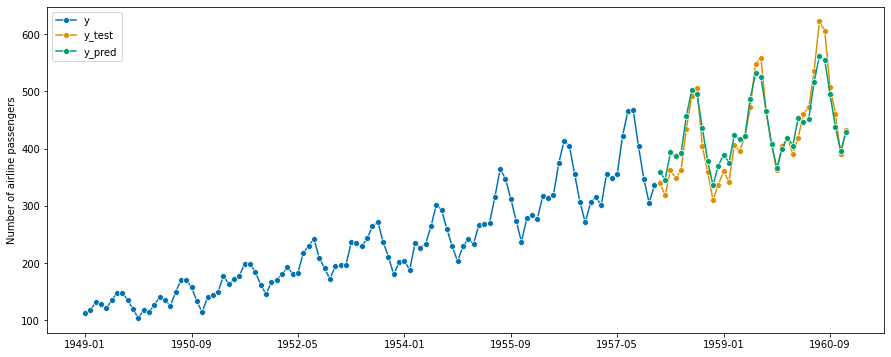

In [ ]:
from sktime.forecasting.compose import AutoEnsembleForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster, STLForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

from sklearn.metrics import mean_squared_error, r2_score


forecasters = [
    ("trend", STLForecaster(sp=12)), 
    # ("poly", PolynomialTrendForecaster(degree=1)),
    # ("expm", ExponentialSmoothing(trend="add")),
    # ("naive", NaiveForecaster()),
] # lags = int(12 * (y.shape[0]/100.)**(1./4))
forecaster = AutoEnsembleForecaster(forecasters=forecasters)
forecaster.fit(y=y_train, fh=fh)
y_pred = forecaster.predict()


# computing the forecast performance
metrics = {
    'mean_squared_error': mean_squared_error(y_test, y_pred),
    'r2_score': r2_score(y_test, y_pred)
}

print(metrics)

# plotting
fig, ax = plt.subplots(figsize=(15,6))
plot_series(y_train, y_test, y_pred, labels=['y', 'y_test', 'y_pred'], ax=ax);

## Checking some models

{'mean_squared_error': 5418.75, 'r2_score': 0.11433812012221978}


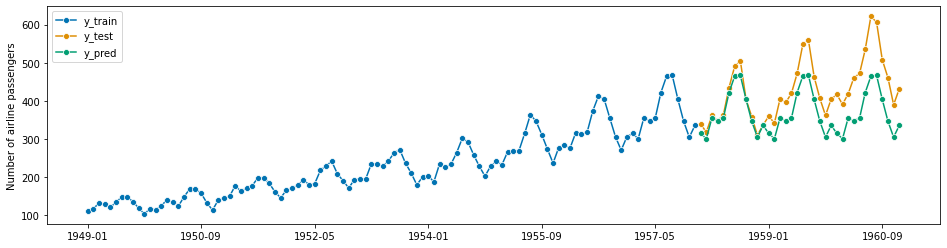

In [ ]:
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

forecasters = [
    # ("trend", STLForecaster(12)),
    # ("poly", PolynomialTrendForecaster(degree=1)),
    # ("expm", ExponentialSmoothing(trend="add")),
    ("naive", NaiveForecaster(strategy="last", sp=12)),
]
forecaster = AutoEnsembleForecaster(forecasters=forecasters)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh = fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# computing the forecast performance
metrics = {
    'mean_squared_error': mean_squared_error(y_test, y_pred),
    'r2_score': r2_score(y_test, y_pred)
}

print(metrics)

{'mean_squared_error': 435.635055387148, 'r2_score': 0.9287980877333624}


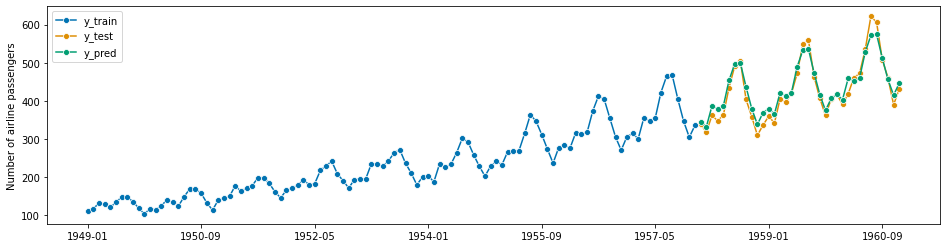

In [ ]:
from sktime.forecasting.arima import ARIMA

forecaster = ARIMA(
    order=(2, 1, 0),
    seasonal_order=(0, 1, 0, 12),
    suppress_warnings=True)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh = fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# computing the forecast performance
metrics = {
    'mean_squared_error': mean_squared_error(y_test, y_pred),
    'r2_score': r2_score(y_test, y_pred)
}

print(metrics)

{'mean_squared_error': 489.8359037668583, 'r2_score': 0.9199392872227382}


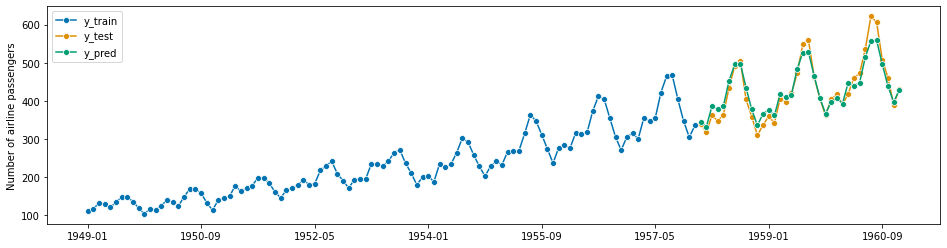

In [ ]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh = fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

# computing the forecast performance
metrics = {
    'mean_squared_error': mean_squared_error(y_test, y_pred),
    'r2_score': r2_score(y_test, y_pred)
}

print(metrics)

/usr/local/lib/python3.7/dist-packages/sktime/forecasting/base/_fh.py:565: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  cutoff = _coerce_to_period(cutoff, freq=cutoff.freqstr)


{'mean_squared_error': 1146.661956422563, 'r2_score': 0.8125850456452982}


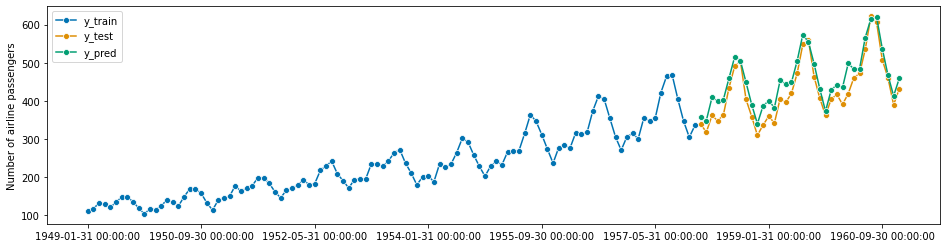

In [ ]:
from sktime.forecasting.fbprophet import Prophet

forecaster = Prophet(
    seasonality_mode="multiplicative",
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)

# Convert index to pd.DatetimeIndex
z = y.copy()
z = z.to_timestamp(freq="M")
z_train, z_test = temporal_train_test_split(z, test_size=36)

forecaster.fit(z_train)
z_pred = forecaster.predict(fh = fh.to_relative(cutoff=y_train.index[-1]))
plot_series(z_train, z_test, z_pred, labels=["y_train", "y_test", "y_pred"])

# computing the forecast performance
metrics = {
    'mean_squared_error': mean_squared_error(z_test, z_pred),
    'r2_score': r2_score(z_test, z_pred)
}

print(metrics)

## Take aways

- Interpolation, Regression and Forecasting are techniques that use diferent methods to make predictions;
- Our world is chaotic thus your time series forecasting task may be more complex (multivariate, etc);
- Model evaluation is crucial, including baseline analysis;
- Validation may require the support of a domain expert that can interpret the results;
- Applications can build expert systems (agents) that use predictions to act automaticaly (predictive controllers).


## Themes for additional discussion

- Model-centric improvements: Machine learning, Deep learning, AutoML;
- Ethics, transparency, reprodutibility and interpretability;
- ...